In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.FESimulator import *
from pyomo.opt import *
import pickle
import os
import six

### Simulating a fed batch reaction
$A + B \rightarrow C$

Initial conditions in reactor: 
* Initial volume $V_0=1L$
* $c_{A0} = 2, c_{B0} = 0, c_{C0} = 0$ (mol/L).

A stream of $B$ with concentration $2 mol/L$ is charged into reactor at rate $0.1 L/min$ over 15min.

Reaction rate constant $k_1=0.1 min^{-1}$

Governing equations are:
$$
\begin{eqnarray}
\frac{dc_A}{dt} &=& -\frac{c_Aqin_B}{V} - k_1c_Ac_B \\
\frac{dc_B}{dt} &=& \frac{(cin_B - c_B)qin_B}{V} - k_1c_Ac_B \\
\frac{dc_C}{dt} &=& -\frac{c_Cqin_B}{V} + k_1c_Ac_B \\
\frac{dV}{dt} &=& qin_B
\end{eqnarray}
$$

In [71]:
builder = TemplateBuilder()  
    
builder.add_mixture_component('A',2.0)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)
    
builder.add_parameter('k1',0.1)

builder.add_algebraic_variable('qin_B')
builder.add_complementary_state_variable('V', 1)
cin_B = 2

In [72]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.Z[t,'A'] * m.Y[t,'qin_B']/m.X[t,'V']-m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = (cin_B*m.Y[t,'qin_B'] - m.Z[t,'B'] * m.Y[t,'qin_B'])/m.X[t,'V']- m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['C'] = -m.Z[t,'C'] * m.Y[t,'qin_B']/m.X[t,'V'] + m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

builder.set_odes_rule(rule_odes)

In [73]:
feed_times=[15, 16]
builder.add_feed_times(feed_times)

In [74]:
model = builder.create_pyomo_model(0, 60)

In [75]:
sim = FESimulator(model)

In [76]:
qinB_traj = read_absorption_data_from_csv('qin_B.csv', directory = "./")

read dir : /home/paperspace/learn_kipet/kipet_examples/qin_B.csv


In [77]:
qinB_traj = pd.DataFrame({'time':[0, 15, 16], 'qin_B':[0.1, 0.1, 0]}).set_index('time')
qinB_traj

,qin_B
time,
0,0.1
15,0.1
16,0.0


In [78]:
inputs_sub = {}
inputs_sub['Y'] = ['qin_B']

In [79]:
sim.apply_discretization('dae.collocation', ncp = 2, nfe = 30, scheme = 'LAGRANGE-RADAU')
sim.fix_from_trajectory('Y', 'qin_B', qinB_traj) 

In [80]:
# this doesn't seem to give the intended profile: at time7.5 it starts having higher values for some reason
for t in sim.model.alltime.value:
    print(t, sim.model.Y[t, 'qin_B']())

0 0.1
1.875 0.1
0.625 0.1
3.75 0.1
2.5 0.1
5.625 0.1
4.375 0.1
7.5 0.85
6.25 0.1
9.375 0.6625
8.125 0.7875
11.25 0.475
10.0 0.6
13.125 0.2875
11.875 0.4125
15 0.1
16 0.0
17.375 0.0
18.75 0.0
13.75 0.225
20.125 0.0
21.5 0.0
22.875 0.0
15.333333 0.06666670000000004
24.25 0.0
25.625 0.0
17.833333 0.0
27.0 0.0
28.375 0.0
29.75 0.0
21.958333 0.0
23.333333 0.0
32.5 0.0
24.708333 0.0
26.083333 0.0
35.25 0.0
27.458333 0.0
28.833333 0.0
38.0 0.0
30.666667 0.0
40.75 0.0
33.416667 0.0
36.166667 0.0
43.5 0.0
38.916667 0.0
41.666667 0.0
46.25 0.0
44.416667 0.0
47.166667 0.0
49.0 0.0
49.916667 0.0
51.75 0.0
52.666667 0.0
54.5 0.0
55.416667 0.0
57.25 0.0
58.166667 0.0
60 0.0
16.458333 0.0
19.208333 0.0
20.583333 0.0


In [81]:
# explicitly imposed the intended profile
for key in sim.model.alltime.value:
    if key <= 15.0:
        sim.model.Y[key, 'qin_B'].set_value(0.1)
        sim.model.Y[key, 'qin_B'].fix()
    else:
        sim.model.Y[key, 'qin_B'].set_value(0.0)
        sim.model.Y[key, 'qin_B'].fix()

In [82]:
for t in sim.model.alltime.value:
    print(t, sim.model.Y[t, 'qin_B']())

0 0.1
1.875 0.1
0.625 0.1
3.75 0.1
2.5 0.1
5.625 0.1
4.375 0.1
7.5 0.1
6.25 0.1
9.375 0.1
8.125 0.1
11.25 0.1
10.0 0.1
13.125 0.1
11.875 0.1
15 0.1
16 0.0
17.375 0.0
18.75 0.0
13.75 0.1
20.125 0.0
21.5 0.0
22.875 0.0
15.333333 0.0
24.25 0.0
25.625 0.0
17.833333 0.0
27.0 0.0
28.375 0.0
29.75 0.0
21.958333 0.0
23.333333 0.0
32.5 0.0
24.708333 0.0
26.083333 0.0
35.25 0.0
27.458333 0.0
28.833333 0.0
38.0 0.0
30.666667 0.0
40.75 0.0
33.416667 0.0
36.166667 0.0
43.5 0.0
38.916667 0.0
41.666667 0.0
46.25 0.0
44.416667 0.0
47.166667 0.0
49.0 0.0
49.916667 0.0
51.75 0.0
52.666667 0.0
54.5 0.0
55.416667 0.0
57.25 0.0
58.166667 0.0
60 0.0
16.458333 0.0
19.208333 0.0
20.583333 0.0


In [83]:
results_pyomo = sim.run_sim('ipopt',tee=True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     1804
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      168

Total number of variables............................:      484
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequali

Text(0.5, 1.0, 'Concentration Profile')

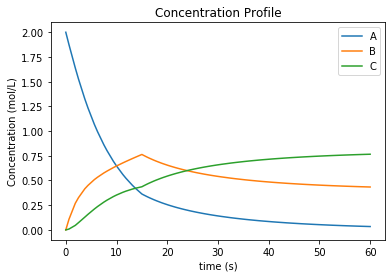

In [84]:
results_pyomo.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")

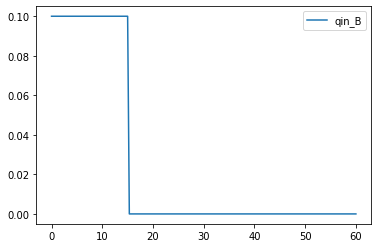

In [85]:
results_pyomo.Y.plot.line(legend=True)

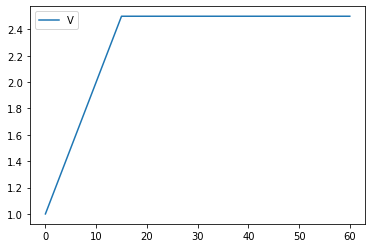

In [86]:
results_pyomo.X.plot.line(legend=True)